In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Grapevine_Leaves_Image_Dataset_Citation_Request.txt
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (20).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (16).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (79).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (55).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (53).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (23).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (42).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (72).png
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Im

In [2]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List

# Data Imports
import pandas as pd
from tqdm import tqdm
from tensorflow import image as tfi

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB7

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

# Model Hypertunning
!pip install -q keras_tuner
cls()
import keras_tuner as kt
import glob
import random


# System libraries
from pathlib import Path
import os.path

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-05-15 17:50:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-15 17:50:04 (48.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # # Force TensorFlow to use single thread
    # # Multiple threads are a potential source of non-reproducible results.
    # session_conf = tf.compat.v1.ConfigProto(
    #     intra_op_parallelism_threads=1,
    #     inter_op_parallelism_threads=1
    # )

    # # Make sure that TensorFlow uses a deterministic operation wherever possible
    # tf.compat.v1.set_random_seed(seed)

    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [5]:
base_dir="/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset"

In [6]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(base_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 1 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset'.
There are 0 directories and 100 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu'.
There are 0 directories and 100 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Ala_Idris'.
There are 0 directories and 100 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Nazli'.
There are 0 directories and 100 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Dimnit'.
There are 0 directories and 100 images in '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Ak'.


In [7]:
import os

# Get all subdirectories of base_dir
all_subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Filter out any subdirectories that do not contain images
class_names = [d for d in all_subdirs if any(fname.endswith(('.jpg', '.png')) for fname in os.listdir(os.path.join(base_dir, d)))]

n_classes = len(class_names)


In [8]:
class_names, n_classes

(['Buzgulu', 'Ala_Idris', 'Nazli', 'Dimnit', 'Ak'], 5)

In [9]:
import os
import shutil
import numpy as np

working_dir = '/kaggle/working/'

# Define train and test split ratio
train_ratio = 0.8

for cls in class_names:
    # Get list of all images
    src_dir = os.path.join(base_dir, cls)
    all_files = os.listdir(src_dir)

    # Randomly shuffle the file list
    np.random.shuffle(all_files)

    # Split into training and testing sets
    train_files = all_files[:int(len(all_files)*train_ratio)]
    test_files = all_files[int(len(all_files)*train_ratio):]

    # Create train and test directories
    train_dir = os.path.join(working_dir, 'Train', cls)
    test_dir = os.path.join(working_dir, 'Test', cls)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy images into respective directories
    for file in train_files:
        shutil.copy(os.path.join(src_dir, file), train_dir)
    for file in test_files:
        shutil.copy(os.path.join(src_dir, file), test_dir)


In [10]:
main_dir="/kaggle/working/"

In [11]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(main_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 2 images in '/kaggle/working/'.
There are 0 directories and 0 images in '/kaggle/working/.virtual_documents'.
There are 5 directories and 0 images in '/kaggle/working/Test'.
There are 0 directories and 20 images in '/kaggle/working/Test/Buzgulu'.
There are 0 directories and 20 images in '/kaggle/working/Test/Dimnit'.
There are 0 directories and 20 images in '/kaggle/working/Test/Nazli'.
There are 0 directories and 20 images in '/kaggle/working/Test/Ala_Idris'.
There are 0 directories and 20 images in '/kaggle/working/Test/Ak'.
There are 0 directories and 1 images in '/kaggle/working/__pycache__'.
There are 5 directories and 0 images in '/kaggle/working/Train'.
There are 0 directories and 80 images in '/kaggle/working/Train/Buzgulu'.
There are 0 directories and 80 images in '/kaggle/working/Train/Dimnit'.
There are 0 directories and 80 images in '/kaggle/working/Train/Nazli'.
There are 0 directories and 80 images in '/kaggle/working/Train/Ala_Idris'.
There ar

In [12]:
train_dir = '/kaggle/working/Train/'
test_dir = '/kaggle/working/Test/'


In [13]:
def convert_path_to_df(dataset, dir_name):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dir_names = pd.Series([dir_name] * len(filepaths), name='Directory')

    # Concatenate filepaths, labels, and directory names
    image_df = pd.concat([filepaths, labels, dir_names], axis=1)
    return image_df

train_df = convert_path_to_df(train_dir, 'train_dir')
test_df = convert_path_to_df(test_dir, 'test_dir')

# Combine all the dataframes
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)


In [14]:
df.head()

,Filepath,Label,Directory
0,/kaggle/working/Train/Buzgulu/Buzgulu (73).png,Buzgulu,train_dir
1,/kaggle/working/Train/Buzgulu/Buzgulu (72).png,Buzgulu,train_dir
2,/kaggle/working/Train/Buzgulu/Buzgulu (100).png,Buzgulu,train_dir
3,/kaggle/working/Train/Buzgulu/Buzgulu (3).png,Buzgulu,train_dir
4,/kaggle/working/Train/Buzgulu/Buzgulu (42).png,Buzgulu,train_dir


In [15]:
from PIL import Image

dir_dict = {train_dir: "Training", test_dir: "Testing"}

data = []

for type_dir, type_label in dir_dict.items():
    for class_name in class_names:
        target_folder = os.path.join(type_dir, class_name)
        for image_file in os.listdir(target_folder):
            img_path = os.path.join(target_folder, image_file)
            with Image.open(img_path) as img:
                data.append({
                    'class_name': class_name,
                    'type': type_label,
                    'img_path': img_path,
                    'shapes': img.size + (len(img.getbands()),)
                })

df = pd.DataFrame(data)
df.head()

,class_name,type,img_path,shapes
0,Buzgulu,Training,/kaggle/working/Train/Buzgulu/Buzgulu (73).png,"(511, 511, 4)"
1,Buzgulu,Training,/kaggle/working/Train/Buzgulu/Buzgulu (72).png,"(511, 511, 4)"
2,Buzgulu,Training,/kaggle/working/Train/Buzgulu/Buzgulu (100).png,"(511, 511, 4)"
3,Buzgulu,Training,/kaggle/working/Train/Buzgulu/Buzgulu (3).png,"(511, 511, 4)"
4,Buzgulu,Training,/kaggle/working/Train/Buzgulu/Buzgulu (42).png,"(511, 511, 4)"


In [16]:
df.class_name.value_counts()

Buzgulu      100
Ala_Idris    100
Nazli        100
Dimnit       100
Ak           100
Name: class_name, dtype: int64

In [17]:
df.shapes.value_counts()

(511, 511, 4)    500
Name: shapes, dtype: int64

In [18]:
# Create separate dataframes for Training and Testing
df_train = df[df['type'] == 'Training']
df_test = df[df['type'] == 'Testing']

df_test.head()

,class_name,type,img_path,shapes
400,Buzgulu,Testing,/kaggle/working/Test/Buzgulu/Buzgulu (48).png,"(511, 511, 4)"
401,Buzgulu,Testing,/kaggle/working/Test/Buzgulu/Buzgulu (87).png,"(511, 511, 4)"
402,Buzgulu,Testing,/kaggle/working/Test/Buzgulu/Buzgulu (65).png,"(511, 511, 4)"
403,Buzgulu,Testing,/kaggle/working/Test/Buzgulu/Buzgulu (84).png,"(511, 511, 4)"
404,Buzgulu,Testing,/kaggle/working/Test/Buzgulu/Buzgulu (80).png,"(511, 511, 4)"


In [19]:
df_train.class_name.value_counts()

Buzgulu      80
Ala_Idris    80
Nazli        80
Dimnit       80
Ak           80
Name: class_name, dtype: int64

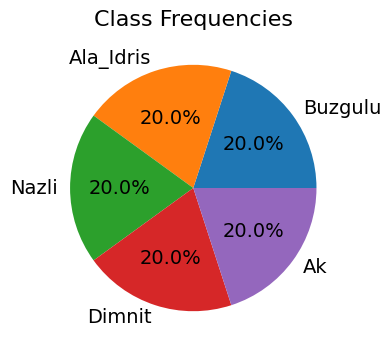

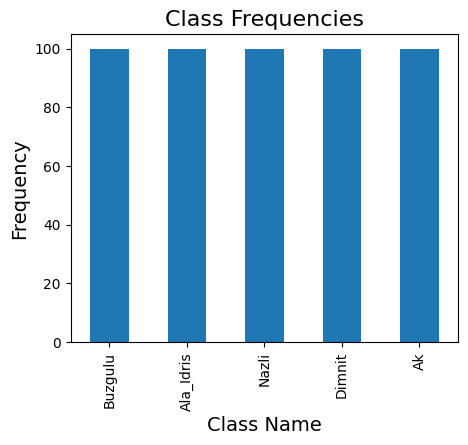

In [20]:
import matplotlib.colors as mcolors

# Create a pie chart of class frequencies
plt.figure(figsize=(5, 4))
df['class_name'].value_counts().plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 14})
plt.title('Class Frequencies', fontsize=16)
plt.ylabel('')
plt.show()
print()

plt.figure(figsize=(5, 4))
df['class_name'].value_counts().plot(kind='bar')
plt.title('Class Frequencies', fontsize=16)
plt.xlabel('Class Name', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [21]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

directories = [train_dir, test_dir]

def check_corrupted_images(directories):
    for directory in directories:
        path = Path(directory).rglob("*.png")
        for img_p in path:
            try:
                img = PIL.Image.open(img_p)
            except PIL.UnidentifiedImageError:
                print(img_p)

check_corrupted_images(directories)

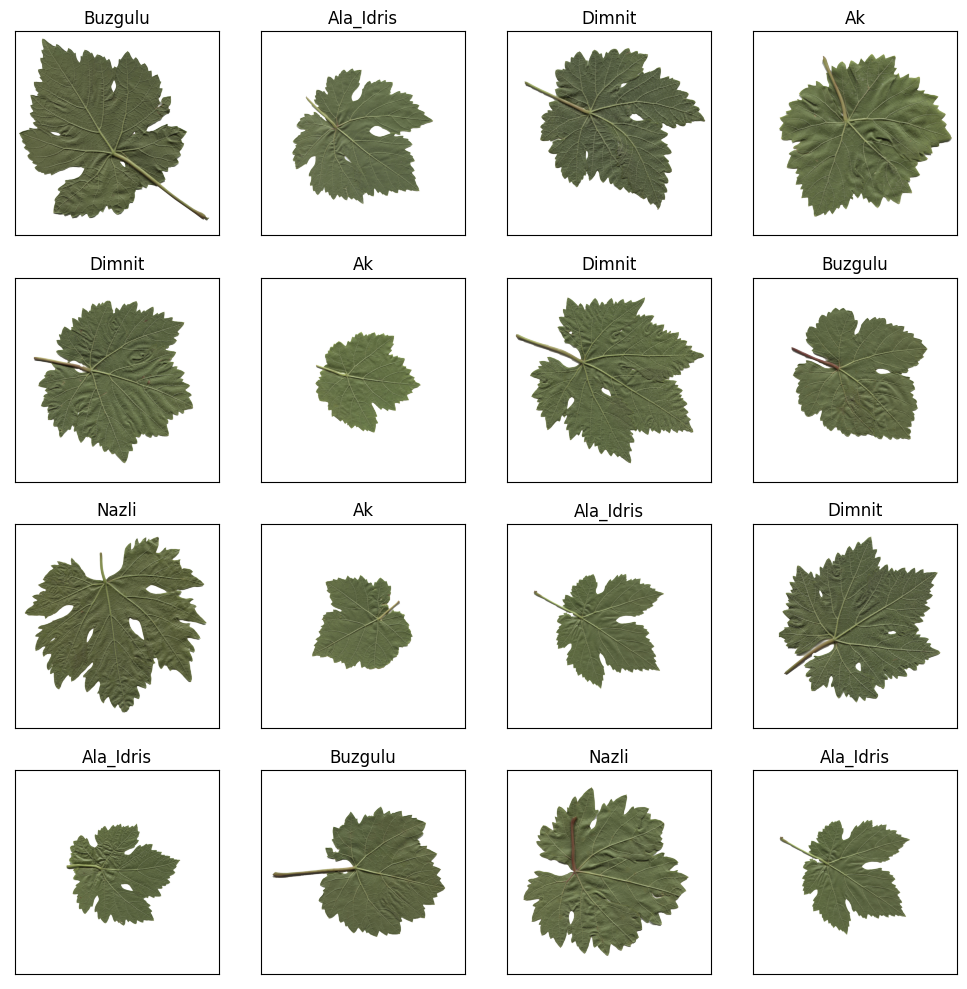

In [22]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.img_path[random_index[i]]))
    ax.set_title(df.class_name[random_index[i]])
plt.tight_layout()
plt.show()

In [23]:
import cv2
from PIL import Image
from PIL import ImageChops
from PIL import ImageEnhance


def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [24]:
import os
import random

def random_sample_from_dataframe(df):
    random_file = random.choice(df['img_path'])
    folder_path, _ = os.path.splitext(random_file)
    parent_dir, _ = os.path.split(folder_path)
    class_name = df.loc[df['img_path'] == random_file, 'class_name'].values[0]
    return parent_dir, class_name

random_parent_dir, random_class_name = random_sample_from_dataframe(df)

# Print the random folder path and check if the file exists
print("Random parent directory:", random_parent_dir)
print("Random class name:", random_class_name)
print("Directory exists:", os.path.exists(random_parent_dir))


Random parent directory: /kaggle/working/Train/Ak
Random class name: Ak
Directory exists: True


In [25]:
random_parent_dir

'/kaggle/working/Train/Ak'

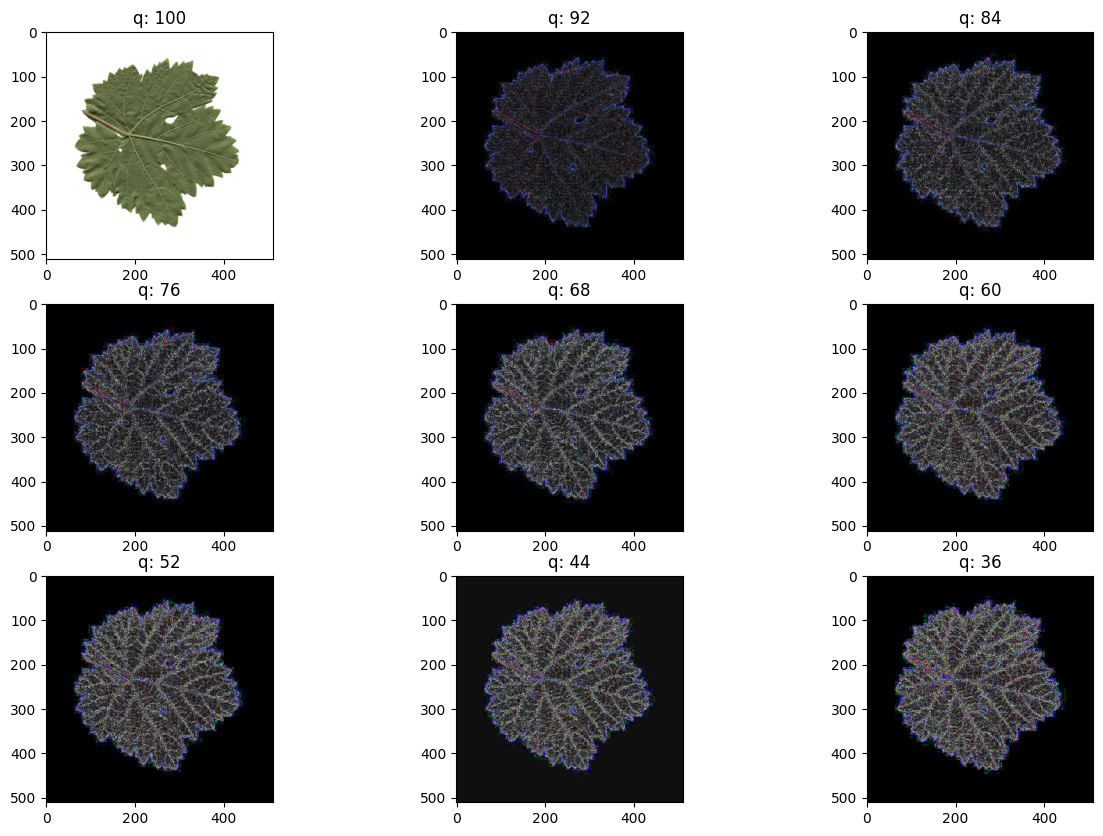

In [26]:
# View random sample from the dataset
p = random_sample(random_parent_dir)

orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

**Create dataset with ImageDataGenerator**

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(height, width, train_dir, test_dir, batch_size):
    # Create ImageDataGenerator training instance with data augmentation
    train_datagen_augmented = ImageDataGenerator(
        rescale=1./255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )

    # Create ImageDataGenerator training instance without data augmentation
    train_datagen = ImageDataGenerator(rescale=1/255.)

    # Create ImageDataGenerator test instance without data augmentation
    test_datagen = ImageDataGenerator(rescale=1/255.)

    # Generate augmented training data
    train_data_augmented = train_datagen_augmented.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    # Generate training data
    train_ds = train_datagen.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical',
        target_size=(height, width),
    )

    # Generate validation data
    val_ds = test_datagen.flow_from_directory(
        test_dir,
        class_mode='categorical',
        target_size=(height, width),
        batch_size=batch_size,
    )

    return train_data_augmented, train_ds, val_ds


In [28]:
batch_size=64

In [29]:
#Setting some inital parameters
height, width = 224, 224

In [30]:
train_data_augmented, train_ds, val_ds = image_generator(height, width, train_dir, test_dir, batch_size)


Found 400 images belonging to 5 classes.
Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [31]:
# Get data batch samples
images, labels = train_ds.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

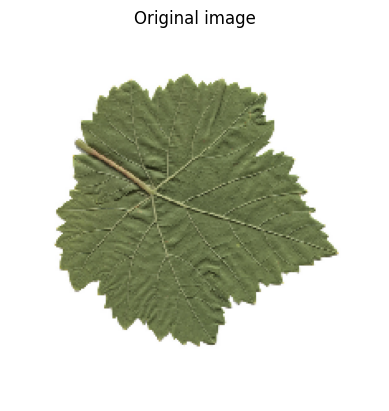

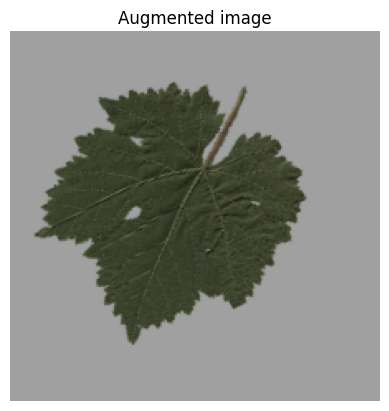

In [32]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

**Backbone Analysis**

In [33]:
# Set some constants for the dataset
BATCH_SIZE = 64 # Number of samples in each batch during training
IMG_SIZE = 224 # Size of the image
AUTOTUNE = tf.data.AUTOTUNE # Set to optimize the buffer size automatically
LEARNING_RATE = 1e-3 # Learning rate for the optimizer used during model training

In [34]:
# Collect all backbones
BACKBONES =[
    ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
    EfficientNetB7(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False),
]

# Define all the backbone names. This will be later used during visualization
BACKBONES_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
    'EfficientNetB7',
]

# Freeze the weights of all the backbones
for backbone in BACKBONES:
    backbone.trainable = False

258076736/258076736 [==============================] - 2s 0us/step


In [39]:
# Set the size of the subset
subset_size = BATCH_SIZE

# Extract data from the generator
X_train, y_train = next(train_data_augmented)

# Generate a random subset of indices
subset_indices = np.random.choice(len(X_train), size=subset_size, replace=False)

# Use the indices to extract a subset of the training data
X_sub, y_sub = X_train[subset_indices], y_train[subset_indices]


In [40]:
len(X_sub), len(y_sub)

(64, 64)

In [37]:
n_classes

5

In [43]:
# Initialize an empty list to hold the histories of each backbone architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for backbone in tqdm(BACKBONES, desc="Training Backbone"):
    
    # Create the simplest model architecture using the current backbone.
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics='accuracy'
    )
    
    # Train the model on the augmented training data.
    history = model.fit(
        train_data_augmented,
        epochs=10,
        validation_data=val_ds,
        steps_per_epoch=subset_size // BATCH_SIZE,
        validation_steps=val_ds.samples // val_ds.batch_size
    )
        
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)
    os.system('cls' if os.name == 'nt' else 'clear')


Training Backbone:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 2.1298 - accuracy: 0.2500 - val_loss: 1.9437 - val_accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.0419 - accuracy: 0.1250 - val_loss: 1.7666 - val_accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.7418 - accuracy: 0.1875 - val_loss: 1.7455 - val_accuracy: 0.2188
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.1786 - accuracy: 0.2656 - val_loss: 1.7057 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.3899 - accuracy: 0.2031 - val_loss: 1.7090 - val_accuracy: 0.2812
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 2.3474 - accuracy: 0.1875 - val_loss: 1.6509 - val_accuracy: 0.2812
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 2.1642 - accuracy: 0.2812 - val_loss: 1.7375 - val_accuracy: 0.2500
Epoch 8/10
1/1 [=========================

Training Backbone:  17%|█▋        | 1/6 [00:34<02:50, 34.10s/it]

Epoch 1/10
1/1 [==============================] - 17s 17s/step - loss: 2.8879 - accuracy: 0.2031 - val_loss: 1.8792 - val_accuracy: 0.2031
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.3622 - accuracy: 0.2188 - val_loss: 1.7956 - val_accuracy: 0.1719
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.3158 - accuracy: 0.2500 - val_loss: 1.7150 - val_accuracy: 0.3281
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.2906 - accuracy: 0.2500 - val_loss: 1.6845 - val_accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.4639 - accuracy: 0.1250 - val_loss: 1.8436 - val_accuracy: 0.2188
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 2.0651 - accuracy: 0.3125 - val_loss: 1.7631 - val_accuracy: 0.2812
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 2.1649 - accuracy: 0.2188 - val_loss: 1.7829 - val_accuracy: 0.2188
Epoch 8/10
1/1 [=======================

Training Backbone:  33%|███▎      | 2/6 [01:18<02:41, 40.41s/it]

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 1.8250 - accuracy: 0.3750 - val_loss: 1.9669 - val_accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.6183 - accuracy: 0.1875 - val_loss: 1.7223 - val_accuracy: 0.2969
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.7106 - accuracy: 0.3281 - val_loss: 1.5955 - val_accuracy: 0.3906
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.7219 - accuracy: 0.4375 - val_loss: 1.5323 - val_accuracy: 0.3125
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.7845 - accuracy: 0.2031 - val_loss: 1.4780 - val_accuracy: 0.3281
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 1.8336 - accuracy: 0.1875 - val_loss: 1.5253 - val_accuracy: 0.2812
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1.8157 - accuracy: 0.2969 - val_loss: 1.4966 - val_accuracy: 0.3281
Epoch 8/10
1/1 [=========================

Training Backbone:  50%|█████     | 3/6 [01:52<01:51, 37.25s/it]

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.6017 - accuracy: 0.3125 - val_loss: 1.8155 - val_accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.9881 - accuracy: 0.1250 - val_loss: 1.7436 - val_accuracy: 0.2344
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 1.8267 - accuracy: 0.1875 - val_loss: 1.7230 - val_accuracy: 0.1719
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.7064 - accuracy: 0.2344 - val_loss: 1.5985 - val_accuracy: 0.2344
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 1.6577 - accuracy: 0.1875 - val_loss: 1.5740 - val_accuracy: 0.2188
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 1.6867 - accuracy: 0.2031 - val_loss: 1.5644 - val_accuracy: 0.2812
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 1.7071 - accuracy: 0.1875 - val_loss: 1.5476 - val_accuracy: 0.2812
Epoch 8/10
1/1 [=========================

Training Backbone:  67%|██████▋   | 4/6 [02:25<01:11, 35.63s/it]

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 2.6488 - accuracy: 0.2031 - val_loss: 1.9990 - val_accuracy: 0.1875
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.5103 - accuracy: 0.1719 - val_loss: 1.8976 - val_accuracy: 0.2031
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.3728 - accuracy: 0.2188 - val_loss: 1.9074 - val_accuracy: 0.2031
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.2119 - accuracy: 0.2344 - val_loss: 1.8750 - val_accuracy: 0.2031
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.3805 - accuracy: 0.0938 - val_loss: 1.8332 - val_accuracy: 0.2344
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.6179 - accuracy: 0.0938 - val_loss: 1.8908 - val_accuracy: 0.2031
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 2.4346 - accuracy: 0.2031 - val_loss: 1.7580 - val_accuracy: 0.2031
Epoch 8/10
1/1 [=========================

Training Backbone:  83%|████████▎ | 5/6 [02:57<00:34, 34.23s/it]

Epoch 1/10


2023-05-15 17:58:02.926270: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 31s 31s/step - loss: 1.7299 - accuracy: 0.1562 - val_loss: 1.6188 - val_accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.5947 - accuracy: 0.2344 - val_loss: 1.6009 - val_accuracy: 0.2344
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 1.6546 - accuracy: 0.1250 - val_loss: 1.6419 - val_accuracy: 0.2344
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.4955 - accuracy: 0.3125 - val_loss: 1.6678 - val_accuracy: 0.1875
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 1.6795 - accuracy: 0.2656 - val_loss: 1.6656 - val_accuracy: 0.2344
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.6929 - accuracy: 0.1250 - val_loss: 1.6969 - val_accuracy: 0.2188
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 1.7407 - accuracy: 0.2031 - val_loss: 1.6821 - val_accuracy: 0.2188
Epoch 8/10
1/1 [==============================] - 

Training Backbone: 100%|██████████| 6/6 [03:57<00:00, 39.53s/it]

In [44]:
import pandas as pd

# Initialize lists to hold accuracy and loss values
train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

# Loop through each history
for history in HISTORIES:
    # Get the final accuracy and loss from each history
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    # Append the accuracy and loss values to the lists
    train_acc_values.append(final_train_acc)
    val_acc_values.append(final_val_acc)
    train_loss_values.append(final_train_loss)
    val_loss_values.append(final_val_loss)

# Create a DataFrame to hold the accuracy and loss values
results_df = pd.DataFrame({
    'Backbone': BACKBONES_NAMES,
    'Train Accuracy': train_acc_values,
    'Validation Accuracy': val_acc_values,
    'Train Loss': train_loss_values,
    'Validation Loss': val_loss_values
})

# Sort the DataFrame by validation accuracy
results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)

# Display the DataFrame
results_df


,Backbone,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
2,InceptionV3,0.25000,0.437500,1.893500,1.379932
4,MobileNetV2,0.28125,0.343750,2.067459,1.635762
0,ResNet50V2,0.21875,0.328125,2.114027,1.588863
1,ResNet152V2,0.25000,0.328125,2.250402,1.519308
3,Xception,0.18750,0.328125,1.665611,1.541281
5,EfficientNetB7,0.18750,0.140625,1.630292,1.666577


In [46]:
HISTORIES_DF = [pd.DataFrame(history) for history in HISTORIES]

# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Backbone', 'Accuracy', 'Loss', 'Val_Accuracy', 'Val_Loss', 'Loss_Difference', 'Accuracy_Difference'])

# Loop over the model training curves
for index, (name, history) in enumerate(zip(BACKBONES_NAMES, HISTORIES_DF)):
    
    # Extract the required metrics at epoch 9
    accuracy = history.loc[9, 'accuracy']
    loss = history.loc[9, 'loss']
    val_accuracy = history.loc[9, 'val_accuracy']
    val_loss = history.loc[9, 'val_loss']

    # Calculate the differences
    loss_difference = min(history['val_loss']) - min(history['loss'])
    accuracy_difference = max(history['val_accuracy']) - max(history['accuracy'])

    # Create a temporary dataframe to store the current row
    temp_df = pd.DataFrame({'Backbone': [name],
                            'Accuracy': [accuracy],
                            'Loss': [loss],
                            'Val_Accuracy': [val_accuracy],
                            'Val_Loss': [val_loss],
                            'Loss_Difference': [loss_difference],
                            'Accuracy_Difference': [accuracy_difference]})

    # Concatenate the temporary dataframe with the results_df
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Display the results table
results_df



,Backbone,Accuracy,Loss,Val_Accuracy,Val_Loss,Loss_Difference,Accuracy_Difference
0,ResNet50V2,0.21875,2.114027,0.328125,1.588863,-0.396574,0.031250
1,ResNet152V2,0.25000,2.250402,0.328125,1.519308,-0.545784,0.015625
2,InceptionV3,0.25000,1.893500,0.437500,1.379932,-0.175388,0.000000
3,Xception,0.18750,1.665611,0.328125,1.541281,-0.090298,0.046875
4,MobileNetV2,0.28125,2.067459,0.343750,1.635762,-0.152252,0.031250
5,EfficientNetB7,0.18750,1.630292,0.140625,1.666577,0.161170,-0.125000


In [52]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# InceptionV3 Backbone
inceptionv3 = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)

# Unfreeze the model weights
inceptionv3.trainable = True

# The InceptionV3 Model baseline
xbaseline = Sequential([
    inceptionv3,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

FINE_TUNING_LEARNING_RATE = 1e-4  # Learning rate for fine-tuning

# Compile the Baseline
xbaseline.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
    metrics=['accuracy']
)

# Train the InceptionV3 Baseline Model
xbaseline.fit(
    train_data_augmented, 
    validation_data=val_ds, 
    epochs=50, 
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("Inceptionv3.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
    ],
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_data_augmented),
)



Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.6677 - accuracy: 0.3375
Epoch 1: val_accuracy improved from -inf to 0.34000, saving model to Inceptionv3.h5
7/7 [==============================] - 42s 2s/step - loss: 1.6677 - accuracy: 0.3375 - val_loss: 1.5374 - val_accuracy: 0.3400
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.1207 - accuracy: 0.5800
Epoch 2: val_accuracy did not improve from 0.34000
7/7 [==============================] - 9s 1s/step - loss: 1.1207 - accuracy: 0.5800 - val_loss: 1.3490 - val_accuracy: 0.3400
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.7225
Epoch 3: val_accuracy improved from 0.34000 to 0.41000, saving model to Inceptionv3.h5
7/7 [==============================] - 9s 1s/step - loss: 0.7560 - accuracy: 0.7225 - val_loss: 1.2161 - val_accuracy: 0.4100
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7925
Epoch 4: val_accuracy improved 

In [54]:
from tensorflow import keras

# Load the model
model = keras.models.load_model('Inceptionv3.h5')

# Optional: Check the model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_17 (Dropout)        (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [57]:
# Testing Evaluation
xtest_loss, xtest_acc = model.evaluate(val_ds)
print(f"Xception Baseline Testing Loss     : {xtest_loss}.")
print(f"Xception Baseline Testing Accuracy : {xtest_acc}.")

2/2 [==============================] - 1s 190ms/step - loss: 0.2727 - accuracy: 0.9100
Xception Baseline Testing Loss     : 0.2727374732494354.
Xception Baseline Testing Accuracy : 0.9100000262260437.


In [58]:
def build_model(hp):
    
    # Define all hyperparms
    n_layers = hp.Choice('n_layers', [0, 2, 4])
    dropout_rate = hp.Choice('rate', [0.2, 0.4, 0.5, 0.7])
    n_units = hp.Choice('units', [64, 128, 256, 512])
    
    # Mode architecture
    model = Sequential([
        inceptionv3,
        GlobalAveragePooling2D(),
    ])
    
    # Add hidden/top layers 
    for _ in range(n_layers):
        model.add(Dense(n_units, activation='relu', kernel_initializer='he_normal'))
    
    # Add Dropout Layer
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(n_classes, activation='softmax'))
    
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer = Adam(LEARNING_RATE),
        metrics = ['accuracy']
    )
    
    # Return model
    return model

In [60]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=10, 
    seed=42, 
    project_name="inceptionv3Search", 
    loss='categorical_crossentropy')

# Start Searching
search = random_searcher.search(
    train_data_augmented,
    validation_data=val_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
)

Trial 10 Complete [00h 01m 59s]
val_loss: 1.2310136556625366

Best val_loss So Far: 0.27743324637413025
Total elapsed time: 00h 20m 10s


In [61]:
# Collect the best model Xception Model Architecture obtained by Random Searcher
best_inceptionv3 = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_inceptionv3.summary()

# Compile Model
best_inceptionv3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

# Model Training
best_inceptionv3_history = best_inceptionv3.fit(
    train_data_augmented,
    validation_data=val_ds,
    epochs = 100,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ModelCheckpoint("BestInceptionv3.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
    ]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.2965 - accuracy: 0.5900
Epoch 1: v

In [64]:
#  Load model 
best_inceptionv3 = keras.models.load_model('BestInceptionv3.h5')
best_inceptionv3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [65]:
best_test_loss, best_test_acc = best_inceptionv3.evaluate(val_ds)
print(f"Test Loss after Tuning     : {best_test_loss} | {xtest_loss}")
print(f"Test Accuracy after Tuning : {best_test_acc}  | {xtest_acc}")

2/2 [==============================] - 2s 185ms/step - loss: 0.0829 - accuracy: 1.0000
Test Loss after Tuning     : 0.08289777487516403 | 0.2727374732494354
Test Accuracy after Tuning : 1.0  | 0.9100000262260437


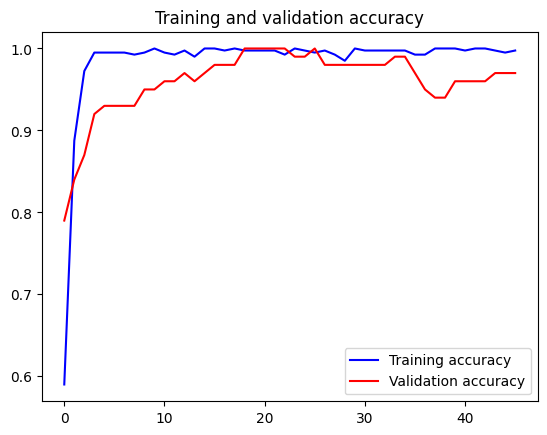

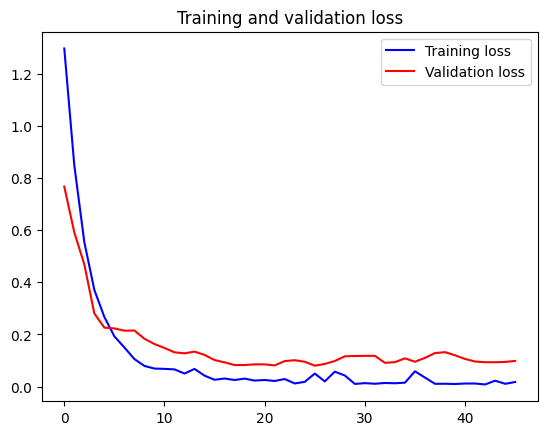

In [67]:
accuracy = best_inceptionv3_history.history['accuracy']
val_accuracy = best_inceptionv3_history.history['val_accuracy']

loss = best_inceptionv3_history.history['loss']
val_loss = best_inceptionv3_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [84]:
predictions = best_inceptionv3.predict(val_ds)
pred = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_true, pred)
print(report)


2/2 [==============================] - 1s 208ms/step
              precision    recall  f1-score   support

           0       0.20      0.20      0.20        20
           1       0.15      0.15      0.15        20
           2       0.25      0.25      0.25        20
           3       0.30      0.30      0.30        20
           4       0.20      0.20      0.20        20

    accuracy                           0.22       100
   macro avg       0.22      0.22      0.22       100
weighted avg       0.22      0.22      0.22       100



In [71]:
# Make predictions with model
pred_probs = best_inceptionv3.predict(val_ds, verbose=1) # set verbosity to see how long it will take 
pred_probs

2/2 [==============================] - 1s 204ms/step


array([[8.66738930e-02, 6.04389489e-01, 1.34756655e-01, 8.80389661e-02,
        8.61409381e-02],
       [2.90556885e-02, 4.51160111e-02, 3.48259509e-02, 7.77099073e-01,
        1.13903299e-01],
       [5.30770572e-04, 9.96706069e-01, 9.60219942e-04, 1.38741464e-03,
        4.15642397e-04],
       [2.20744070e-04, 9.98695314e-01, 3.12378863e-04, 6.27159316e-04,
        1.44356236e-04],
       [1.77336711e-04, 1.31986206e-04, 1.49629268e-04, 2.93780526e-04,
        9.99247313e-01],
       [4.50740708e-03, 3.90922278e-03, 2.65268213e-03, 9.86212015e-01,
        2.71865260e-03],
       [1.16333493e-03, 1.19842857e-03, 9.95527327e-01, 1.27563055e-03,
        8.35196231e-04],
       [5.78212494e-04, 8.20710324e-04, 4.74575936e-04, 9.97337639e-01,
        7.88813399e-04],
       [9.85666215e-01, 3.59918503e-03, 4.11446718e-03, 4.24524676e-03,
        2.37488910e-03],
       [1.22745207e-03, 1.03936577e-03, 1.23353547e-03, 1.71319465e-03,
        9.94786382e-01],
       [1.58117656e-02, 2.8150

In [72]:
# How many predictions are there?
len(pred_probs)

100

In [73]:
# What's the shape of our predictions?
pred_probs.shape

(100, 5)

In [80]:
# Get the class predicitons of each label
y_pred = pred_probs.argmax(axis=1)

# How do they look?
y_pred[:10]

array([1, 3, 1, 1, 4, 3, 2, 3, 0, 4])

In [79]:
y_true = val_ds.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [81]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


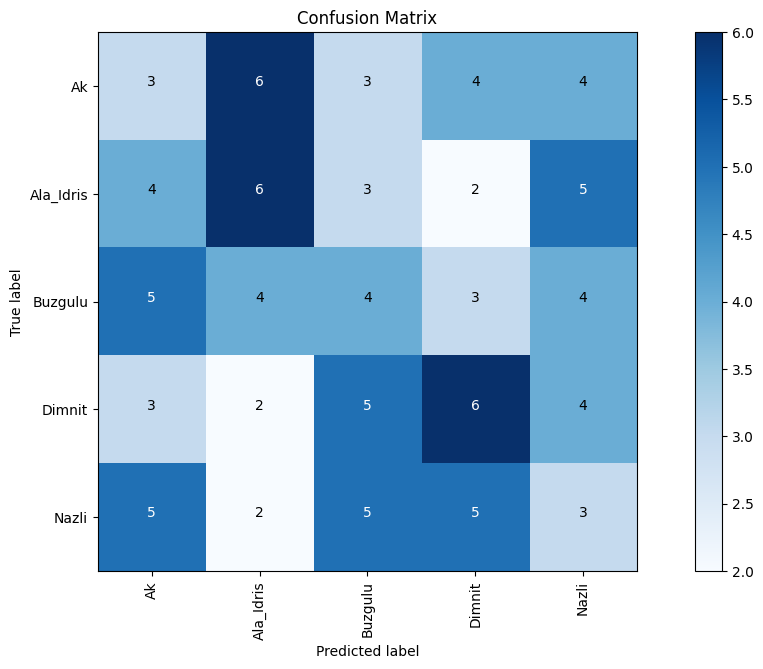

In [82]:
# Now you have y_true and y_pred and you can use them to make a confusion matrix
make_confusion_matrix(y_true, y_pred, classes=val_ds.class_indices, figsize=(15, 7), text_size=10, norm=False, savefig=False)


In [ ]:
make_confusion_matrix(y_test_class_names, pred_class_names, classes=class_names, figsize=(15, 7), text_size=10, norm=False, savefig=False)


In [87]:
def make_predictions_on_sample(model, dataset, num_samples=15):
    """
    Function to make predictions on random samples from a given dataset.

    Args:
        model: trained model.
        dataset: dataset where samples will be randomly selected.
        num_samples: number of samples to make predictions on.
    """
    # Get the class labels from the dataset's class_indices
    class_labels = list(dataset.class_indices.keys())

    # Select a few random batches from the dataset
    for _ in range(num_samples):
        random_batch = random.choice(range(len(dataset)))
        batch = dataset[random_batch]  # this is a batch: (images, labels)

        # Randomly select an image from the batch
        random_index = random.choice(range(batch[0].shape[0]))
        image = batch[0][random_index]
        true_label = np.argmax(batch[1][random_index])

        # Make a prediction using the model
        image_expanded = np.expand_dims(image, axis=0)  # expand dimensions for prediction
        prediction = model.predict(image_expanded)
        predicted_label = np.argmax(prediction)

        # Determine the color of the text (green for correct, red for incorrect)
        text_color = "green" if true_label == predicted_label else "red"

        # Plot the image and the prediction
        plt.imshow(image)
        plt.title(f"True label: {class_labels[true_label]} \n Predicted label: {class_labels[predicted_label]}", color=text_color)
        plt.axis('off')
        plt.show()


In [91]:
def make_predictions_on_sample(model, dataset, num_samples=15):
    """
    Function to make predictions on random samples from a given dataset.

    Args:
        model: trained model.
        dataset: dataset where samples will be randomly selected.
        num_samples: number of samples to make predictions on, should be a multiple of 3.
    """
    assert num_samples % 3 == 0, "num_samples should be a multiple of 3 for consistent display."

    # Get the class labels from the dataset's class_indices
    class_labels = list(dataset.class_indices.keys())

    # Select a few random batches from the dataset
    for i in range(num_samples // 3):
        fig, axs = plt.subplots(1, 3, figsize=(15,5))  # prepare subplots for 3 images

        for ax in axs:  # for each subplot
            random_batch = random.choice(range(len(dataset)))
            batch = dataset[random_batch]  # this is a batch: (images, labels)

            # Randomly select an image from the batch
            random_index = random.choice(range(batch[0].shape[0]))
            image = batch[0][random_index]
            true_label = np.argmax(batch[1][random_index])

            # Make a prediction using the model
            image_expanded = np.expand_dims(image, axis=0)  # expand dimensions for prediction
            prediction = model.predict(image_expanded, verbose=0)
            predicted_label = np.argmax(prediction)

            # Determine the color of the text (green for correct, red for incorrect)
            text_color = "green" if true_label == predicted_label else "red"

            # Plot the image and the prediction
            ax.imshow(image)
            ax.set_title(f"True: {class_labels[true_label]} \n Predicted: {class_labels[predicted_label]}", color=text_color)
            ax.axis('off')

        plt.show()  # show the 3 images



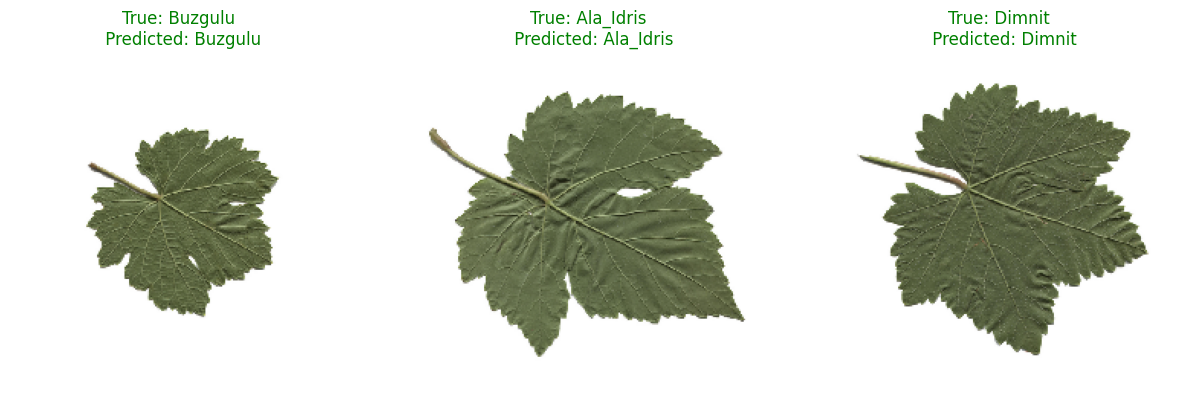

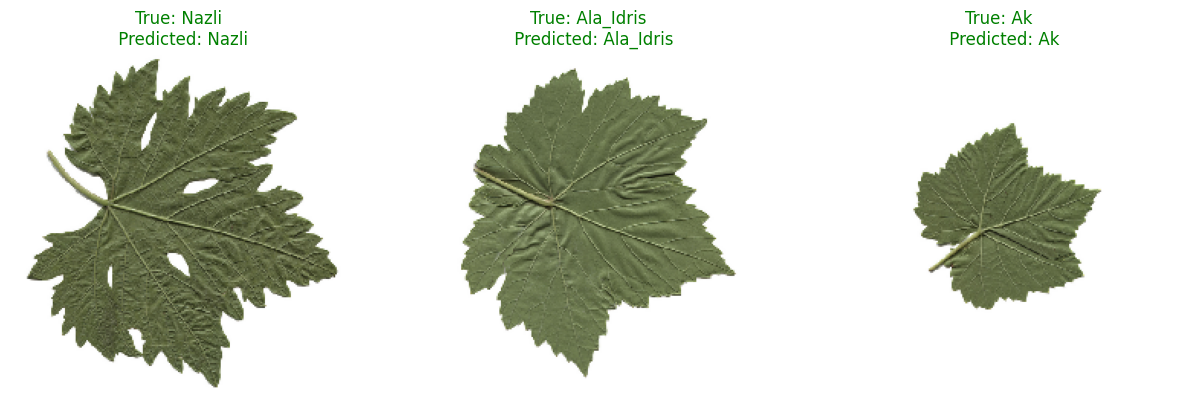

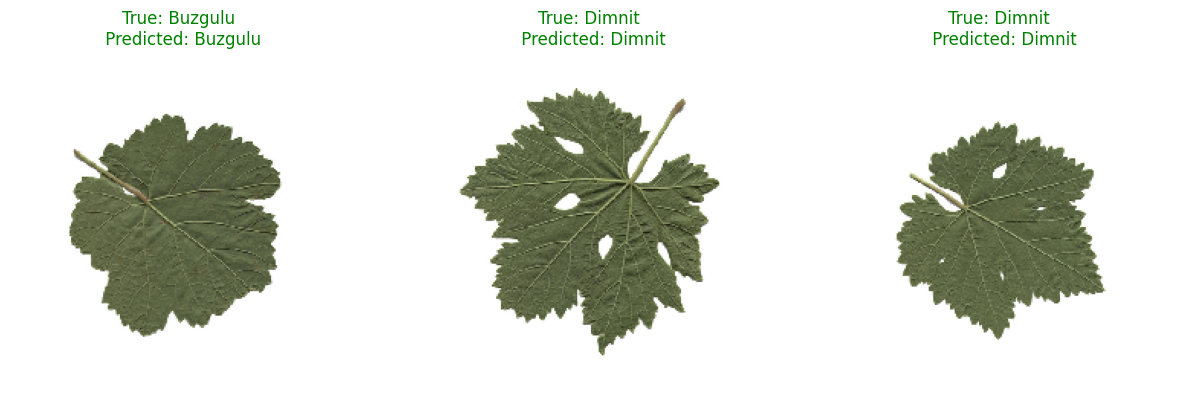

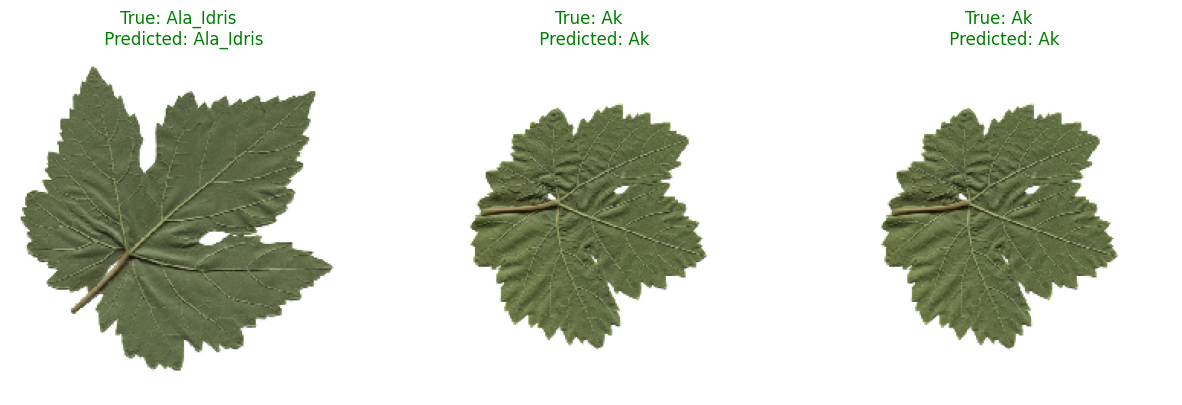

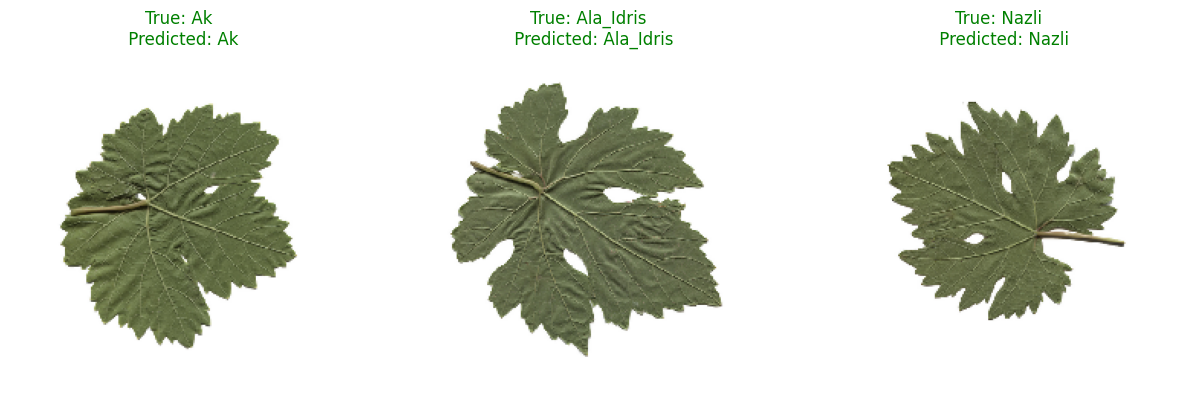

In [92]:
make_predictions_on_sample(best_inceptionv3, val_ds, num_samples=15)
